In [1]:
from itertools import product
import pprint

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.datasets import load_diabetes, load_iris

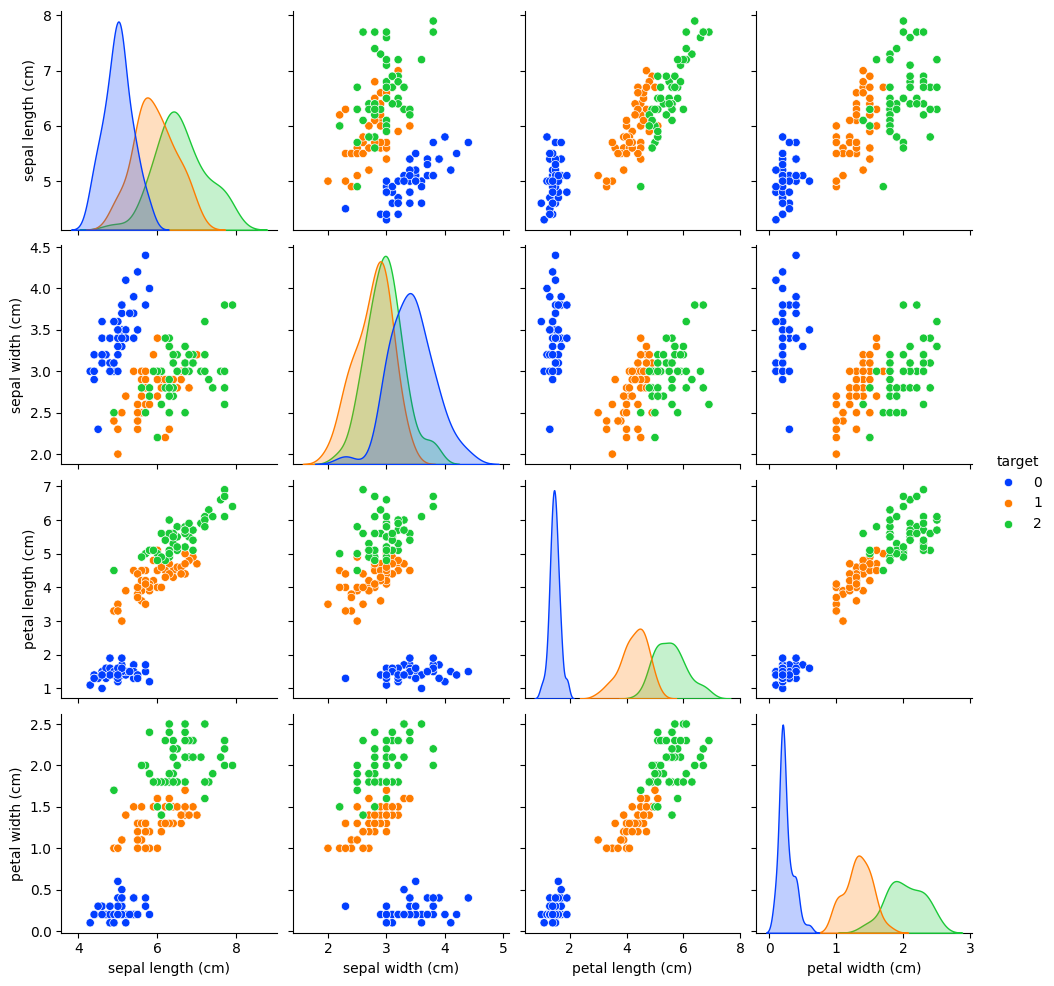

In [3]:
iris = load_iris(as_frame=True).frame   # Load the iris dataset from sklearn
X = iris.drop("target", axis=1).values  # Drop the "Species" column
y = iris["target"].values               # Separate the "Species" column

sns.pairplot(iris, hue='target', palette='bright')

Separate dataset into training and testing data with split ratio of 80-20%

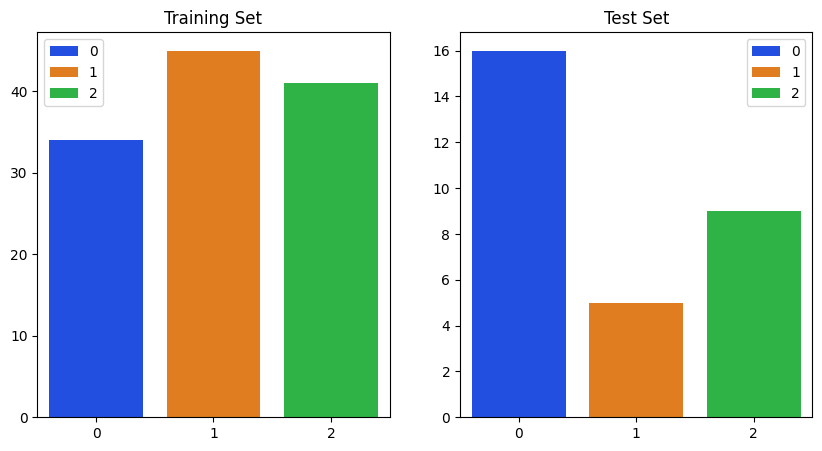

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
unique, counts = np.unique(y_train, return_counts=True)
sns.barplot(x=unique, y=counts, palette='bright', hue=unique, ax=ax[0])
ax[0].set_title('Training Set')

unique, counts = np.unique(y_test, return_counts=True)
sns.barplot(x=unique, y=counts, palette='bright', hue=unique, ax=ax[1])
ax[1].set_title('Test Set')
plt.show()

#Fixing the data set helps with the being able to debug, whether the issue is coming from the model or the data set 
#note the test set is NOT split into well distbruted classes 

We can use stratified split to ensure that ratio of all classes remain same in training and test data. This is useful when we have imbalanced dataset
and want to ensure that that training and test data have same distribution of classes.

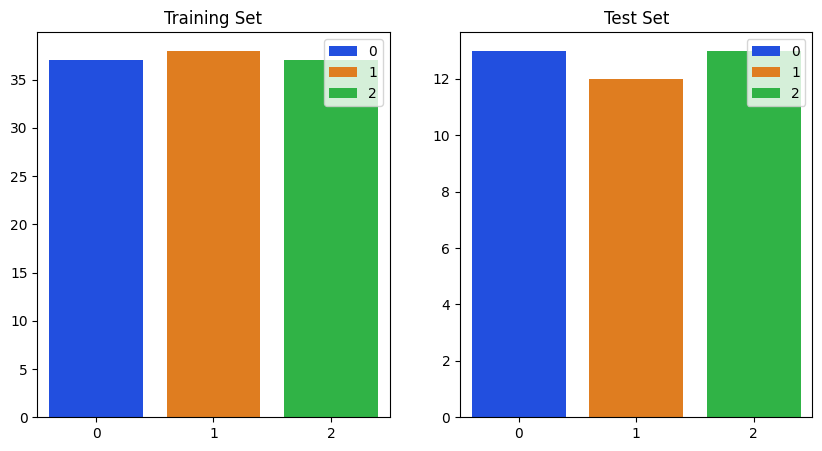

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=4) #adding paramter for stratify

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
unique, counts = np.unique(y_train, return_counts=True)
sns.barplot(x=unique, y=counts, palette='bright', hue=unique, ax=ax[0])
ax[0].set_title('Training Set')

unique, counts = np.unique(y_test, return_counts=True)
sns.barplot(x=unique, y=counts, palette='bright', hue=unique, ax=ax[1])
ax[1].set_title('Test Set')
plt.show()

#if data set is highly skewed this may not help 


## Scaling the data

### Normalisation

#### Using `numpy`

In [6]:
X_train_normalised = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))
X_test_normalised = (X_test - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))

print(f"min: {X_train_normalised.min(axis=0)}, max: {X_train_normalised.max(axis=0)} \n")
print(X_train_normalised[:4])

#must scale data. must have values from 0 to 1 

min: [0. 0. 0. 0.], max: [1. 1. 1. 1.] 

[[0.44117647 0.29166667 0.49152542 0.45833333]
 [0.55882353 0.58333333 0.74576271 0.91666667]
 [0.32352941 0.58333333 0.08474576 0.125     ]
 [0.61764706 0.5        0.59322034 0.58333333]]


Normalise the data using `MinMaxScaler`

In [7]:
normaliser = MinMaxScaler()
normaliser.fit(X_train)
X_train_normalised = normaliser.transform(X_train)
X_test_normalised = normaliser.transform(X_test)

print(f"min: {X_train_normalised.min(axis=0)}, max: {X_train_normalised.max(axis=0)} \n")
print(X_train_normalised[:4])

min: [0. 0. 0. 0.], max: [1. 1. 1. 1.] 

[[0.44117647 0.29166667 0.49152542 0.45833333]
 [0.55882353 0.58333333 0.74576271 0.91666667]
 [0.32352941 0.58333333 0.08474576 0.125     ]
 [0.61764706 0.5        0.59322034 0.58333333]]


### Standardisation

#### Manually scale using numpy.

In [8]:
X_train_mean, X_train_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train_scaled = (X_train - X_train_mean) / X_train_std
X_test_scaled = (X_test - X_train_mean) / X_train_std

print(f"mean: {X_train_scaled.mean(axis=0)}, std: {X_train_scaled.std(axis=0)}")

# same transformation as normal distribution standardixzation 
# #test scaled using training set statistics 

mean: [-2.90789218e-15 -1.70498536e-16 -5.98727417e-16  2.09158088e-16], std: [1. 1. 1. 1.]


#### Scale the data using `StandardScaler`.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)        # Only fit the training data and not the testing data

print(f"mean: {X_train_scaled.mean(axis=0)}, std: {X_train_scaled.std(axis=0)}")

#1.4 q 1, need to fill in with knn nieghbours can only use that on training data set. you have to apply the same model that came from training on the test 
#really you should never see test data, it really should be hidden 

mean: [-2.90789218e-15 -1.70498536e-16 -5.98727417e-16  2.09158088e-16], std: [1. 1. 1. 1.]


## IMPORTANT: It is very important to only "fit" the scaler or normaliser on training data and then use the same scaler to transform test data. This is to avoid DATA LEAKAGE.

In [10]:
def compute_acc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return {"Accuracy": acc, "F1 Score": f1, "Precision": precision, "Recall": recall}

### KNN Classifier

{'Accuracy': 0.9473684210526315,
 'F1 Score': np.float64(0.9473684210526315),
 'Precision': np.float64(0.9473684210526315),
 'Recall': np.float64(0.9473684210526315)}


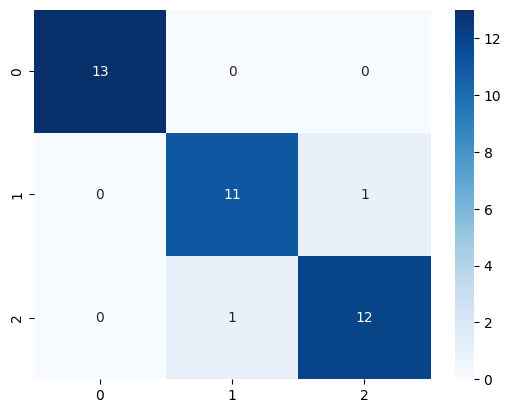

In [11]:
knn_clf = KNeighborsClassifier(n_neighbors=5) #parameter is number of nieghbours, initalising step 

# Fit the model
knn_clf.fit(X_train_scaled, y_train) # y is just 0 1 or 2 so it doesnt need to be scaled s

# Predict the labels
y_pred = knn_clf.predict(X_test_scaled)

# Calculate accuracy metrics
metrics = compute_acc_metrics(y_test, y_pred)
pprint.pprint(metrics)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

### Random Forest Classifier

{'Accuracy': 0.9210526315789473,
 'F1 Score': np.float64(0.9210526315789473),
 'Precision': np.float64(0.9229082321187584),
 'Recall': np.float64(0.9210526315789473)}


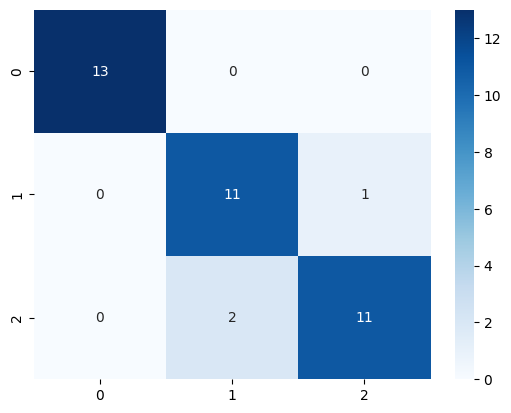

In [12]:
rf_clf = RandomForestClassifier(criterion="gini")
rf_clf.fit(X_train_scaled, y_train)
y_pred = rf_clf.predict(X_test_scaled)

metrics = compute_acc_metrics(y_test, y_pred)
pprint.pprint(metrics)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

Let's try tweaking the hyperparameters of Random Forest Classifier to see if we can find a better model.

In [13]:
for (criterion, min_samples_split) in product(['gini', 'entropy'], np.arange(0.05, 1, 0.05)): #starts at 5% split up to 95% split in increments of 5% 
    rf_clf = RandomForestClassifier(criterion=criterion, min_samples_split=min_samples_split)
    cv_scores = cross_val_score(rf_clf, X_train_scaled, y_train, cv=10, n_jobs=-1, scoring="f1_macro")
    print(f"criterion = {criterion}\t min_samples_split = {min_samples_split:.2f}:\t mean={cv_scores.mean():.5f}\t std={cv_scores.std():.5f}")

criterion = gini	 min_samples_split = 0.05:	 mean=0.95582	 std=0.05794
criterion = gini	 min_samples_split = 0.10:	 mean=0.95582	 std=0.05794
criterion = gini	 min_samples_split = 0.15:	 mean=0.96534	 std=0.05657
criterion = gini	 min_samples_split = 0.20:	 mean=0.96534	 std=0.05657
criterion = gini	 min_samples_split = 0.25:	 mean=0.93804	 std=0.06805
criterion = gini	 min_samples_split = 0.30:	 mean=0.93804	 std=0.06805
criterion = gini	 min_samples_split = 0.35:	 mean=0.93889	 std=0.05484
criterion = gini	 min_samples_split = 0.40:	 mean=0.93884	 std=0.08656
criterion = gini	 min_samples_split = 0.45:	 mean=0.92111	 std=0.08932
criterion = gini	 min_samples_split = 0.50:	 mean=0.94624	 std=0.05931
criterion = gini	 min_samples_split = 0.55:	 mean=0.93693	 std=0.06981
criterion = gini	 min_samples_split = 0.60:	 mean=0.92085	 std=0.08119
criterion = gini	 min_samples_split = 0.65:	 mean=0.84054	 std=0.15755
criterion = gini	 min_samples_split = 0.70:	 mean=0.42940	 std=0.33048
criter

We can automate the ablove grid search for hyperparameter tuning using `GridSearchCV`.

Fitting 5 folds for each of 38 candidates, totalling 190 fits
[CV] END .............criterion=gini, min_samples_split=0.05; total time=   0.1s
[CV] END .............criterion=gini, min_samples_split=0.05; total time=   0.1s
[CV] END .............criterion=gini, min_samples_split=0.05; total time=   0.1s
[CV] END ..............criterion=gini, min_samples_split=0.1; total time=   0.1s
[CV] END ..............criterion=gini, min_samples_split=0.1; total time=   0.1s
[CV] END .............criterion=gini, min_samples_split=0.05; total time=   0.1s
[CV] END .............criterion=gini, min_samples_split=0.05; total time=   0.1s
[CV] END ..............criterion=gini, min_samples_split=0.1; total time=   0.1s
[CV] END ..............criterion=gini, min_samples_split=0.1; total time=   0.1s
[CV] END criterion=gini, min_samples_split=0.15000000000000002; total time=   0.1s
[CV] END criterion=gini, min_samples_split=0.15000000000000002; total time=   0.1s
[CV] END criterion=gini, min_samples_split=

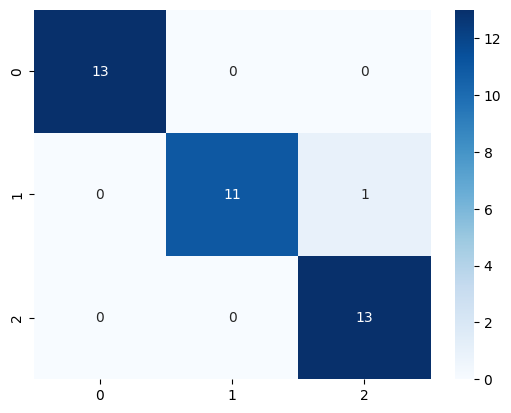

In [14]:
parameters = {
    "criterion": ["gini", "entropy"], #python list
    "min_samples_split": np.arange(0.05, 1, 0.05),
}#python dictonary 

rf_clf = RandomForestClassifier()
grid_search = GridSearchCV(rf_clf #MLmodel
                           , parameters, cv=5, n_jobs=-1#something to do with machine
                           , scoring="f1_macro", verbose=2 #verbose makes it print out lots of things
                           )
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

y_pred = grid_search.predict(X_test_scaled) #will predict best value 
metrics = compute_acc_metrics(y_test, y_pred)
pprint.pprint(metrics)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()


### Support Vector Classifier

{'Accuracy': 0.9736842105263158,
 'F1 Score': np.float64(0.9736842105263158),
 'Precision': np.float64(0.9757085020242916),
 'Recall': np.float64(0.9736842105263158)}


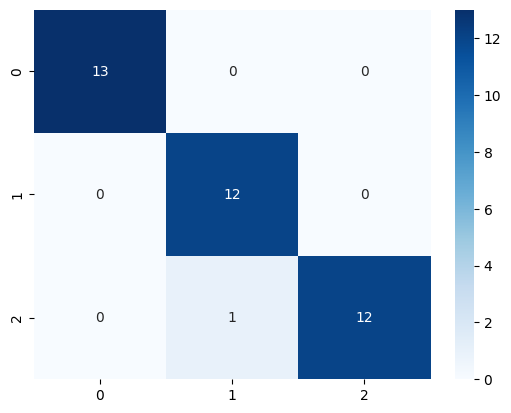

In [15]:
svc_clf = SVC(kernel="linear") #can try different kernals 
svc_clf.fit(X_train_scaled, y_train)
y_pred = svc_clf.predict(X_test_scaled)

metrics = compute_acc_metrics(y_test, y_pred)
pprint.pprint(metrics)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

### Regression Models

In [22]:
diabetes = load_diabetes(as_frame=True).frame
X = diabetes.drop("target", axis=1).values
y = diabetes["target"].values
print(X)
print(y)

[[ 0.03807591  0.05068012  0.06169621 ... -0.00259226  0.01990749
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ... -0.03949338 -0.06833155
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.00259226  0.00286131
  -0.02593034]
 ...
 [ 0.04170844  0.05068012 -0.01590626 ... -0.01107952 -0.04688253
   0.01549073]
 [-0.04547248 -0.04464164  0.03906215 ...  0.02655962  0.04452873
  -0.02593034]
 [-0.04547248 -0.04464164 -0.0730303  ... -0.03949338 -0.00422151
   0.00306441]]
[151.  75. 141. 206. 135.  97. 138.  63. 110. 310. 101.  69. 179. 185.
 118. 171. 166. 144.  97. 168.  68.  49.  68. 245. 184. 202. 137.  85.
 131. 283. 129.  59. 341.  87.  65. 102. 265. 276. 252.  90. 100.  55.
  61.  92. 259.  53. 190. 142.  75. 142. 155. 225.  59. 104. 182. 128.
  52.  37. 170. 170.  61. 144.  52. 128.  71. 163. 150.  97. 160. 178.
  48. 270. 202. 111.  85.  42. 170. 200. 252. 113. 143.  51.  52. 210.
  65. 141.  55. 134.  42. 111.  98. 164.  48.  96.  90. 162. 150. 279.
  92.  83. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Intercept: 153.73654390934846, Coefficients: [  1.75375799 -11.51180908  25.60712144  16.82887167 -44.44885564
  24.64095356   7.67697768  13.1387839   35.16119521   2.35136365]
MSE: 2900.19, R^2: 0.45


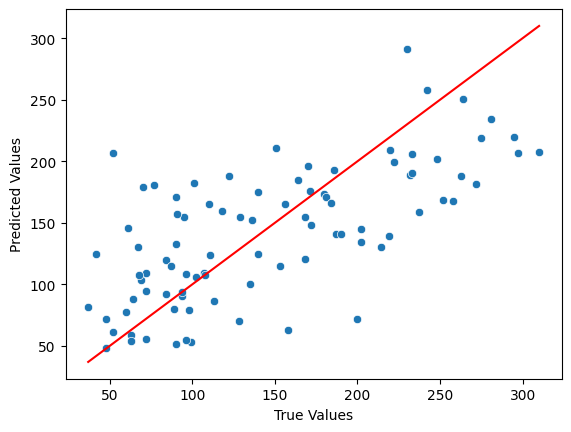

In [111]:
elastic_lm = LinearRegression(fit_intercept=True)
elastic_lm.fit(X_train_scaled, y_train)
print(f"Intercept: {elastic_lm.intercept_}, Coefficients: {elastic_lm.coef_}")

y_pred = elastic_lm.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}, R^2: {r2:.2f}")

sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=y_test, y=y_test, color='r')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

### Ridge Regression

In [112]:
ridge_lm = Ridge(alpha=0.8)
ridge_lm.fit(X_train_scaled, y_train)
y_pred = ridge_lm.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, R^2: {r2:.2f}")

# norm 2

MSE: 2893.21, R^2: 0.45


### Lasso Regression

In [113]:
lasso_lm = Lasso(alpha=0.8)
lasso_lm.fit(X_train_scaled, y_train)
y_pred = lasso_lm.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, R^2: {r2:.2f}")

# norm 1 (abs value one? )

MSE: 2836.57, R^2: 0.46


### Elastic Net

In [20]:
elastic_lm = ElasticNet(alpha=0.8, l1_ratio=0.5)
elastic_lm.fit(X_train_scaled, y_train)
y_pred = elastic_lm.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, R^2: {r2:.2f}")

MSE: 2868.41, R^2: 0.46


The MSE and R2 score remain pretty much the same. Let's try adding some polynomial features using `PolynomialFeatures`.

In [115]:
X_train_poly = PolynomialFeatures(degree=3).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=3).fit_transform(X_test)

scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

elastic_lm = ElasticNet(alpha=1, l1_ratio=0.6)
elastic_lm.fit(X_train_poly, y_train)

y_pred = elastic_lm.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, R^2: {r2:.2f}")

MSE: 2863.68, R^2: 0.46


### Search over various l1_ratios

In [116]:
elastic_lm = ElasticNetCV(l1_ratio=np.arange(0.1, 1, 0.05))
elastic_lm.fit(X_train_scaled, y_train)

print(f"Best alpha: {elastic_lm.alpha_}, Best l1_ratio: {elastic_lm.l1_ratio_}")

y_pred = elastic_lm.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MSE: {mse:.2f}, R^2: {r2:.2f}")
#behind the scenes is Line Search? 

Best alpha: 0.15485952718826052, Best l1_ratio: 0.3500000000000001
MSE: 2857.22, R^2: 0.46


In [21]:
from sklearn.preprocessing import OneHotEncoder

iris = load_iris(as_frame=True).frame
iris['categorical'] = np.random.choice(['a', 'b', 'c'], iris.shape[0]) # generate categorical data
X, y = iris.drop('target', axis=1), iris['target']

onehot = OneHotEncoder(sparse_output=False)
X_cat = onehot.fit_transform(X[['categorical']])
X = np.hstack((X.drop('categorical', axis=1), X_cat))
X

#allows you to have the categories be incorperated within th datafram in a way useful to the any ML algo 
# Now follow the usual steps as before starting from splitting the data

array([[5.1, 3.5, 1.4, ..., 0. , 1. , 0. ],
       [4.9, 3. , 1.4, ..., 0. , 1. , 0. ],
       [4.7, 3.2, 1.3, ..., 0. , 1. , 0. ],
       ...,
       [6.5, 3. , 5.2, ..., 0. , 1. , 0. ],
       [6.2, 3.4, 5.4, ..., 0. , 0. , 1. ],
       [5.9, 3. , 5.1, ..., 1. , 0. , 0. ]])

In [118]:
# Alternatively, we can use pandas to one-hot encode the categorical data

iris = load_iris(as_frame=True).frame
X, y = iris.drop('target', axis=1), iris['target']
X['categorical'] = np.random.choice(['a', 'b', 'c'], iris.shape[0])

col_names = ['categorical_1', 'categorical_2', 'categorical_3']
cat_features = pd.get_dummies(X['categorical'], prefix='categorical', dtype=np.int64)
X = pd.concat([X.drop('categorical', axis=1), cat_features], axis=1)
X

#look up sklearn pipeline and preprocessing pipline learn

#Pandas has SQL functions , never good to have preproccessin in either pandas or sklearn, 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),categorical_a,categorical_b,categorical_c
0,5.1,3.5,1.4,0.2,0,1,0
1,4.9,3.0,1.4,0.2,0,0,1
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,0,0,1
4,5.0,3.6,1.4,0.2,0,1,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1,0,0
146,6.3,2.5,5.0,1.9,0,1,0
147,6.5,3.0,5.2,2.0,1,0,0
148,6.2,3.4,5.4,2.3,0,0,1


Scikit-learn is a powerful framework that provides a range of supervised and unsupervised learning algorithms through a consistent interface in Python. Much of its capabilities are often
unexplored. The best place to start is the official documentation and spending time understanding how the various hyperparameters affect the model is crucial.